```Yizhou ~ 2020 8 30:
I think there are something uncompatible between SKlearn and my code, so I will try another implementaion```


In [1]:
import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);


path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation";

os.chdir(path);
from PMT_compressed_sensing_simu import Compressed_sensing_PMT as CSP;

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/Eigen Face";
os.chdir(path);


import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

#plt.style.use("seaborn-ticks")

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [2]:
## convert the dataframe into np.array
df = pd.read_csv('face_data.csv');
X = df.drop('target', axis=1);
X = X.values;
y = df['target'];
y = y.values;

r = 64;
c = 64;

## check the eigen_value and eigen vector
## check the eigen_value and eigen vector
def Check_Eigen(X):
    X_mean = np.mean(X, axis = 0);
    X_centered = X - X_mean;
    S = X_centered.T.dot(X_centered) / (len(X_centered)-1);
    eigen_val, eigen_vec = np.linalg.eig(S);

    r,c = X.shape;
    n_comp = min(r,c);
    eigen_vec = eigen_vec[:,:n_comp];    
    return eigen_val, eigen_vec, X_mean;

X_train, X_test, y_train, y_test = train_test_split(X, y);
eigen_val, eigen_vec, X_train_mean = Check_Eigen(X_train);

print(eigen_val.shape)
print(eigen_vec.shape)



(4096,)
(4096, 300)


In [3]:
## train model
pca = PCA(svd_solver='full').fit(X_train);
X_train_pca = pca.transform(X_train);
classifier = SVC().fit(X_train_pca, y_train);

In [4]:
class Strategy(object):
    def __init__(self):
        self.prop = {};

    def add_item(self, name, item):
        if name not in self.prop:
            self.prop[name] = item;
        else:
            print("Item name already exists.");
    
    def rm_item(self, name):
        if name in self.prop:
            del self.prop[name];
        else:
            print("Item name doesn't exist.")

def get_greatest(eigen_val, threshold = 0.1): ## eigen values are sorted!
    for i in range(len(eigen_val)):
        if eigen_val[i] < eigen_val[0] * 0.1:
            Break;
    return i;

def get_accuracy(model, x_test, target):
    prediction = model.predict(x_test);
    return np.mean(prediction == target);

In [5]:
time_list = [0.01, 0.1, 1, 10,100,1000,10000];
time_list = [60.]
compression_rate = 1;
cycles = int(compression_rate * r * c);
CS = Strategy();

random_mask = np.round(np.random.rand(cycles, (r*c)));
unit_mask = np.eye((r*c));

CS.add_item("phi", random_mask);

CS.add_item("cycles", len(CS.prop['phi'][:,0]));

CS.add_item("psi", eigen_vec.astype(float));
CS.add_item("n_photon", 1e6);
CS.add_item("measure", []);
CS.add_item("recons",[]);
CS.add_item("error", []);
CS.add_item("time_list", time_list);

CS.add_item("accuracy",[]);

In [6]:
print(X_train_mean.shape)

(4096,)


In [7]:
select = np.random.randint(len(y_test));
y_select = y[select: select+10];
CS.add_item("data", X_test[select : select+10, :]);
#CS.add_item("data", X_test);
CS.add_item("true_coef", ((CS.prop['data'] - X_train_mean).dot(CS.prop['psi'])));

CS.add_item("recon_coef", []);

pmt = CSP();



0 / 1
Mini-batch (size 10) Gradient Ascent!

{cost = 1.266e+05} |··················································| 0.0%
{cost = 3.071e+01} |>>>>>>>>>>········································| 20.0%
{cost = 2.711e+01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.702e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.609e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.108e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

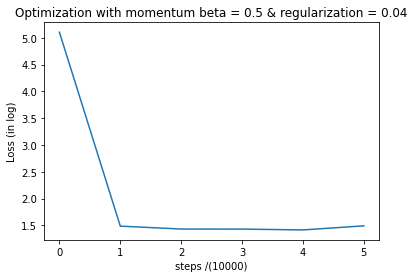

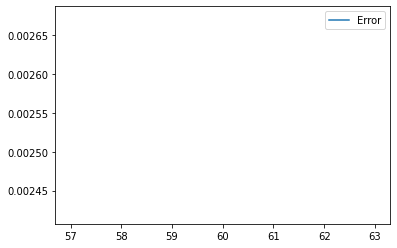

In [8]:
Obj = CS;
time_list = Obj.prop['time_list'];
## start measurement!
Obj.prop['measure'] = [];
Obj.prop['error'] = [];
Obj.prop['recons'] = [];
Obj.prop['recon_coef'] = [];
Obj.prop['accuracy'] = [];

Poisson = False;
phi = Obj.prop['phi'];
psi = Obj.prop['psi'];

#psi = dct_mtx;
m = psi;
#phi = np.ceil(m / (2 * np.max(abs(m))))[:Obj.prop['cycles'],:];

for time in time_list:
    light_level = Obj.prop['n_photon'] * time / (r*c) / Obj.prop['cycles'];
    measure = phi.dot(Obj.prop['data'].T); ## need to be transposed

    if Poisson:
        measure = np.random.poisson(measure * light_level) / light_level;

    measure -= (phi.dot(X_train_mean)).reshape(-1,1);
    Obj.prop['measure'].append(measure);


regu = 4e-2

for time_index in range(len(time_list)):
    print(time_index, '/', len(time_list));
    measure = Obj.prop['measure'][time_index];
    measure = np.array(measure).reshape(len(measure[:,0]), -1);
    pmt.PMT_reconstruct(r_tot = r, c_tot = c, measurement = measure, 
                        upload_DMD_basis = phi, upload_phi= psi, 
                        user_evaluation = False, learning_rate = 2e-3, 
                        regularization = regu, plot_step= 10000, max_epoch = 50000, display = False); 
                        ## It should be upload_psi，是一个笔误

    Obj.prop['recons'].append(pmt.img_reconstructed_vector + X_train_mean.reshape(-1,1));
    Obj.prop['recon_coef'].append(pmt.W);

    Obj.prop['accuracy'].append(get_accuracy(classifier, pmt.W.T, y_select))
    
    this_error = (np.mean((Obj.prop['recons'][-1] - Obj.prop['data'].T)**2));   
    Obj.prop['error'].append(this_error); 


plt.figure(facecolor='w');
plt.plot(time_list, Obj.prop['error'], label = 'Error');
plt.legend();
plt.show();

In [9]:
X_select_pca = pca.transform(Obj.prop['data']);

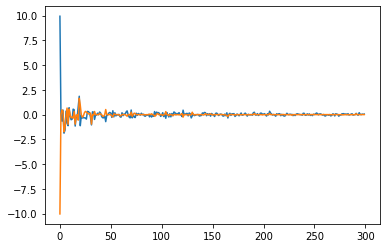

In [11]:
plt.figure(facecolor='w');
plt.plot(X_select_pca[1]);
plt.plot(pmt.W[:,1])


In [ ]:
Obj.prop['accuracy']

In [ ]:
## predict
plt.figure(facecolor='w');
plt.plot(time_list, Obj.prop['accuracy'], label = 'Error');
plt.legend();
plt.show();

In [ ]:
pmt.W.shape

In [ ]:
CS.prop['data'].shape